## 1. 变分自编码器 variational autoencoder (VAE)

[VAE论文](https://arxiv.org/pdf/1312.6114)

这里有篇很好的文章：[From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)

In [5]:
from IPython.display import Image, display
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png'
display(Image(url=url, width=600))

In [6]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/VAE-graphical-model.png'
display(Image(url=url, width=600))

In [7]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png'
display(Image(url=url, width=600))

第一张图：autoencoder可以看作是矩阵分解，类比SVD  
第二张图：概率图模型框架下VAE，观测由隐变量z生成  
第三张图：VAE的一些细节。可以用很多词对去描述这个过程，比如编码-解码；降维-升维；压缩-还原；推入-拉回。从观测到潜在分布，称之为学习；从潜在分布生成数据，称之为推断。  

---

## 2. 数学表达式

模型假定数据$x$由某个潜变量$z$生成

潜变量$z$具有某个先验分布$p(z)$，一般假定为标准正态分布. $z\sim N(0,I)$

模型的联合概率分布为 $p_\theta(x,z)=p_\theta(x|z)p(z)$

目标是最大化$x$的边缘似然 $$p_\theta(x)=\int p_\theta(x|z)p(z)dz$$

因为积分计算困难，引入变分推断。

---

引入变分分布$q_\phi(z|x)$迫近真实后验分布$p_\theta(z|x)$

为衡量迫近程度，需要度量两个分布之间的距离，使其最小化。采用KL散度，根据定义
$$D_{KL}(q_\phi(z|x)||p_\theta(z|x)) = \mathbb{E}_{q_\phi(z|x)}\left[log\frac{q_\phi(z|x)}{p_\theta(z|x)}\right] $$

注：实际上，我们定义了一个的参数分布族$\{p_\theta\}_{\theta\in\Theta}$

然后寻找最优分布以最小化某个损失函数$L(\theta)$，这是一类泛函极值问题，来源于最速降线问题。

变分推断另一个常见的场景是混合高斯模型（Gaussian Mixture Model，GMM）

---

**琴生不等式**  
如果f(x)是凸函数  
在二元情况下有：$\frac{f(x_1)+f(x_2)}{2}\geqslant f(\frac{x_1+x_2}{2})$  

在n元情况下有：$\frac{f(x_1)+f(x_2)+\cdots+f(x_n)}{n}\geqslant f(\frac{x_1+x_2+\cdots+x_n}{n})$ 

由于琴生不等式在加权的情况下也成立，即
$\frac{\alpha_1f(x_1)+\alpha_2f(x_2)+\cdots+\alpha_nf(x_n)}{\alpha_1+\alpha_1+\cdots+\alpha_n}\geqslant f(\frac{\alpha_1x_1+\alpha_2x_2+\cdots+\alpha_nx_n}{\alpha_1+\alpha_1+\cdots+\alpha_n})$  

不等式左边是函数值的期望，右边是期望的函数值，即 $\mathbb{E}[f(x)]\geqslant f(\mathbb{E}(x))$  

在f(x)是凹函数的情况下，有对应的不等式。log(x)是凹函数，于是 $\mathbb{E}[log(x)]\leqslant log(\mathbb{E}(x))$

---

目标的对数边缘似然：
$$\log p_\theta(x)=\log \int p_\theta(x,z)dz=\log \int \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz$$


$$\geqslant \int \log \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x,z)}{q_\phi(z|x)}
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x|z) p(z)}{q_\phi(z|x)}$$

$$=\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)-D_{KL}(q_\phi(z|x)||p(z))$$

不等式右边的结果称为证据下界（evidence lower bound, ELBO），又称变分下界或负变分自由能。  
ELBO由两项构成，第一项称为重构项，衡量解码器从潜在变量z重构数据x的能力，类似于自编码器的重建损失（如交叉熵或均方误差）；第二项是正则项，约束近似后验接近先验，防止过拟合。  
下界的意思是至少是这么多，因此为了最大化目标函数，就需要最大化ELBO，等价与最小化ELBO的负值（优化理论约定），于是有
$$\arg \mathop{\min}_{\theta,\phi}D_{KL}(q_\phi(z|x)||p(z))-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)$$


---

编码器建模：$q_\phi(z|x)$  

通常假定为对角高斯分布。$q_\phi(z|x)=\mathcal{N}(z;\mu_\phi(x),\sigma_\phi^2(x))$ 

解码器建模：$p_\theta(x|z)$  

根据数据类型选择分布：二值数据（如黑白的MNIST）用伯努利分布；连续数据（如CIFAR-10, 256个值）用高斯分布。

为了收敛性，使用重参数化技巧（[Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)），采样$z\sim q_\phi(z|x)$，于是  

$z=\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon, \epsilon \sim \mathcal{N}(0, I) $


In [9]:
url = 'https://gregorygundersen.com/image/reparam/vae.png'
display(Image(url=url, width=600))

因为$q_\phi(z|x)$是对角高斯分布，$p(z)$是标准正态分布，则$D_{KL}(q_\phi(z|x)||p(z))$项有闭式解。  
$$D_{KL}(\mathcal{N}(\mu_\phi(x),\sigma^2_\phi(x)I)||\mathcal{N}(0,I))
=\frac{1}{2}\sum_{i=1}^d(\mu_i^2+\sigma^2_i-1-ln\sigma^2_i)$$

第二项，通过蒙特卡洛方法计算，但一般只取一个样本！

---

后续优化：
（1）$\beta$-VAE：引入超参数$\beta$，强化正则项。$\mathcal{L}(\theta, \phi)=-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)+\beta\cdot D_{KL}(q_\phi(z|x)||p(z))$     

论文[$\beta$-VAE](https://www.cs.toronto.edu/~bonner/courses/2022s/csc2547/papers/generative/disentangled-representations/beta-vae,-higgins,-iclr2017.pdf)

（2）CVAE：引入条件变量$y$，建模$p_\theta(x|z,y)$  

论文[CVAE](https://arxiv.org/pdf/1812.04405)

（3）VQVAE：使用向量量化（Vector Quantization）改进潜在表示。

论文[VQVAE](https://arxiv.org/pdf/1711.00937)

## 3. 简单实现

In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
# 超参数
image_size = 256
downscale = 4
batch_size = 4
in_channels = 3
out_channels = 3
epochs = 100
learning_rate = 1e-4
save_path = 'model_pkl/vae_updated.pth'
data_path = 'data/celeba_hq_256/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
# CelebA-HQ Super-Resolution Dataset
class CelebASuperRes(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, size=256, downscale=4):
        self.root = root
        self.transform = transform
        self.size = size
        self.downscale = downscale
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx])).convert('RGB')
        hr = transforms.Resize((self.size, self.size))(img)
        lr = transforms.Resize((self.size // self.downscale, self.size // self.downscale))(hr)
        lr = transforms.Resize((self.size, self.size), interpolation=Image.BICUBIC)(lr)
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return hr, lr

In [5]:
dataset = CelebASuperRes(data_path, transform=transform, size=image_size, downscale=downscale)
subset_dataset = Subset(dataset, range(500))
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unloader = transforms.ToPILImage()

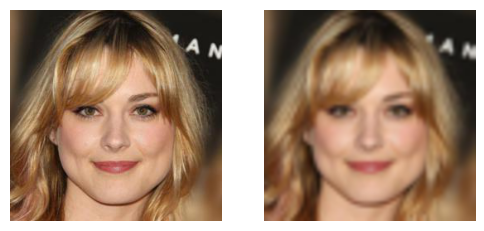

In [6]:
for x, y in dataloader:
    img1, img2 = x[0], y[0]
    img1 = denormalize(img1, mean, std)[0]
    img2 = denormalize(img2, mean, std)[0]
    img1 = unloader(img1)
    img2 = unloader(img2)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')
    plt.show()
    break

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            # nn.GroupNorm(8, in_channels),
            # nn.GELU(),
            # nn.Conv2d(in_channels, in_channels, 3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q, k, v = self.qkv(x_norm).chunk(3, dim=1)
        q, k, v = [t.reshape(B, C, H * W).transpose(1, 2) for t in (q, k, v)]  # B, HW, C

        attn = torch.bmm(q, k.transpose(1, 2)) * (C ** -0.5)
        attn = attn.softmax(dim=-1)
        out = torch.bmm(attn, v).transpose(1, 2).reshape(B, C, H, W)
        return x + self.proj(out)

In [9]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ResBlock(in_channels),
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
        )

    def forward(self, x):
        return self.block(x)

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ResBlock(in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
        )

    def forward(self, x):
        return self.block(x)

In [10]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()

        # ----------------- Encoder -----------------
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            ResBlock(64),
        )  # -> 256x256
        self.enc2 = Downsample(64, 128)      # -> 128x128
        self.enc3 = Downsample(128, 256)     # -> 64x64
        self.attn1 = AttentionBlock(256)

        self.enc4 = Downsample(256, 512)     # -> 32x32
        self.attn2 = AttentionBlock(512)

        # self.enc5 = Downsample(512, 512)     # -> 16x16
        # self.attn3 = AttentionBlock(512)

        self.to_latent = nn.Conv2d(512, latent_dim, 3, padding=1)
        self.conv_mu = nn.Conv2d(latent_dim, latent_dim, 1)
        self.conv_logvar = nn.Conv2d(latent_dim, latent_dim, 1)

        # ----------------- Decoder -----------------
        self.dec_in = ResBlock(latent_dim)

        self.up1 = Upsample(latent_dim, 256)    # 32x32 → 64x64
        self.attn_dec1 = AttentionBlock(256)

        self.up2 = Upsample(256 + 256, 128)     # 64x64 → 128x128
        self.attn_dec2 = AttentionBlock(128)

        self.up3 = Upsample(128 + 128, 64)     # 128x128 → 256x256
        # self.up4 = Upsample(64 + 64, 32)      

        self.final = nn.Sequential(
            nn.Conv2d(64 + 64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_channels, 3, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.attn1(self.enc3(s2))
        s4 = self.attn2(self.enc4(s3))
        # s5 = self.attn3(self.enc5(s4))
        z = self.to_latent(s4)
        mu = self.conv_mu(z)
        logvar = self.conv_logvar(z)
        return mu, logvar, [s1, s2, s3, s4]

    def decode(self, z, skips):
        x = self.dec_in(z)
        x = self.up1(x)
        x = self.attn_dec1(x)
        x = self.up2(torch.cat([x, skips[2]], dim=1))
        x = self.attn_dec2(x)
        x = self.up3(torch.cat([x, skips[1]], dim=1))
        # x = self.up4(torch.cat([x, skips[0]], dim=1))
        x = self.final(torch.cat([x, skips[0]], dim=1))
        return x

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skips)
        return recon, mu, logvar

In [12]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

In [13]:
## 初始化模型
model = VAE()
# summary(model, input_size=(4, 3, 256, 256))

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [19]:
model.to(device)
scaler = GradScaler()
best_loss = float('inf')  # 初始化为正无穷
accumulation_steps = 16  # 定义累积步数
for epoch in range(4):
    model.train()
    total_loss, total_recon, total_kl = 0.0, 0.0, 0.0

    # beta = min(1.0, epoch / 10.0)  # KL warmup
    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    optimizer.zero_grad()
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)

        with autocast(device_type='cuda'):
            recon, mu, logvar = model(images)
            loss, recon_loss, kl_div = vae_loss(recon, images, mu, logvar)

        loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        total_recon += recon_loss.item()
        total_kl += kl_div.item()

        pbar.set_postfix(loss=total_loss)

    # 补充最后一组未step的梯度
    if (batch_idx + 1) % accumulation_steps != 0:
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print("Best model saved.")

Epoch 1:   0%|                                                                                 | 0/250 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [16]:
def load_vae(model, checkpoint_path, device='cuda'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [11]:
model_vae=VAE().to(device)
model_vae.load_state_dict(torch.load('model_pkl/vae_updated.pth'))
model_vae.eval()

C:\Users\sheng\AppData\Local\Temp\ipykernel_72292\2826984077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae.load_state_dict(torch.load('model_pkl/vae_updated.

VAE(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResBlock(
      (block): Sequential(
        (0): GroupNorm(8, 64, eps=1e-05, affine=True)
        (1): GELU(approximate='none')
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (enc2): Downsample(
    (block): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): GroupNorm(8, 64, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (enc3): Downsample(
    (block): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): GroupNorm(8, 128, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [12]:
def plot_images(original_images, reconstructed_images, n_row=2, n_col=2):
    original_images = original_images.detach().cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()
    
    fig, axes = plt.subplots(n_row, n_col * 2, figsize=(8, 4))
    
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            if idx >= original_images.shape[0]:
                continue
            axes[i, j * 2].imshow(np.transpose(original_images[idx], (1, 2, 0)))
            axes[i, j * 2].set_title("Original")
            axes[i, j * 2].axis('off')

            axes[i, j * 2 + 1].imshow(np.transpose(reconstructed_images[idx], (1, 2, 0)))
            axes[i, j * 2 + 1].set_title("Reconstructed")
            axes[i, j * 2 + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

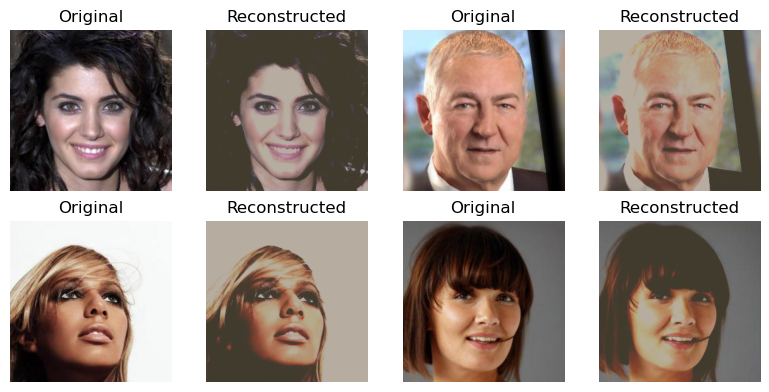

In [17]:
# 获取并展示重建的图像
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

model_vae.eval()
with torch.no_grad():
    sample_data, _ = next(iter(dataloader))
    sample_data = sample_data.to(device)
    original_images = sample_data
    original_images = denormalize(original_images, mean=mean, std=std)
    reconstructed_images = model_vae(sample_data)[0]
    reconstructed_images = denormalize(reconstructed_images, mean=mean, std=std)
    plot_images(original_images, reconstructed_images)